In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import fitsio
import astropy.table as astTable
import lsst.afw.image as afwImage
import glob
import os
from astropy.visualization import ZScaleInterval
import h5py

def load_ancil_as_dict(h5_path):
    out = {}
    with h5py.File(h5_path, "r") as f:
        g = f["/ancil"]
        for k, obj in g.items():
            if isinstance(obj, h5py.Dataset):
                arr = obj[()]  # load this dataset only
                if isinstance(arr, np.ndarray) and arr.dtype.kind == "S":
                    arr = arr.astype(str)  # bytes->str if needed
                out[k] = arr
            # (optional) recurse into subgroups if you have nested structure
            elif isinstance(obj, h5py.Group):
                out[k] = {kk: g[k][kk][()] for kk in g[k].keys()}
    return out
    
if False:
    a = load_ancil_as_dict("/gpfs02/work/tqzhang/s23b_pz_v2/hectomap_noshear_fzboost.hdf5")
    ccc = h5py.File("/gpfs02/work/tqzhang/s23b_pz_v2/hectomap_noshear_fzboost.hdf5", "r")
    ccc.keys()
    np.array(ccc["meta"]["xvals"])
    dd = np.array(ccc["data"]["yvals"])

In [ ]:
fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/spring1.fits"
dd = fitsio.read(fname)
fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields_color/spring1.fits"
d = fitsio.read(fname)
msk = (dd["ra"] > 152) & (dd["dec"] < 154) & (dd["dec"] >4.1)
dd2 = dd[msk]
d2 = d[msk]

Text(0.5, 1.0, 'i_flux_gauss2_err')

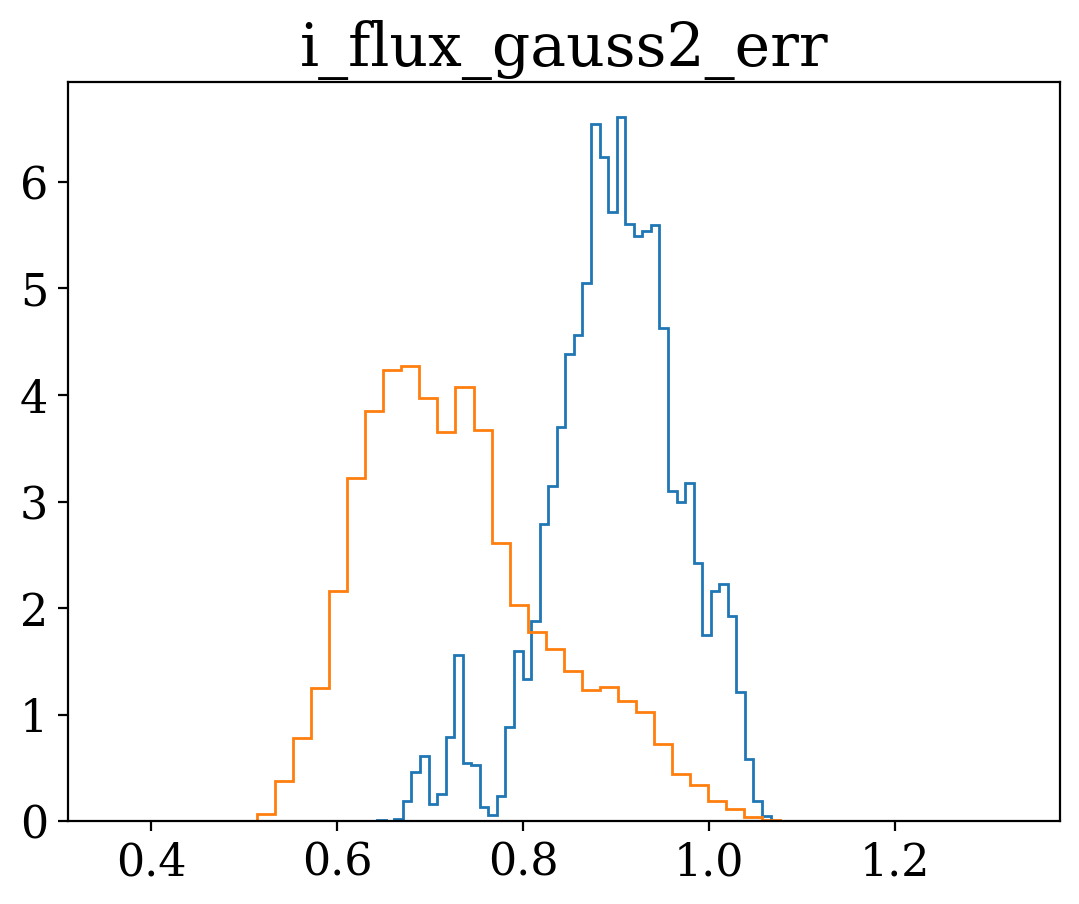

In [82]:
plt.hist(dd2["i_flux_gauss2_err"], bins=50, histtype="step", density=True)
plt.hist(dd["i_flux_gauss2_err"], bins=50, histtype="step", density=True)
plt.title("i_flux_gauss2_err")

Text(0.5, 1.0, 'i_pixel_noise_std')

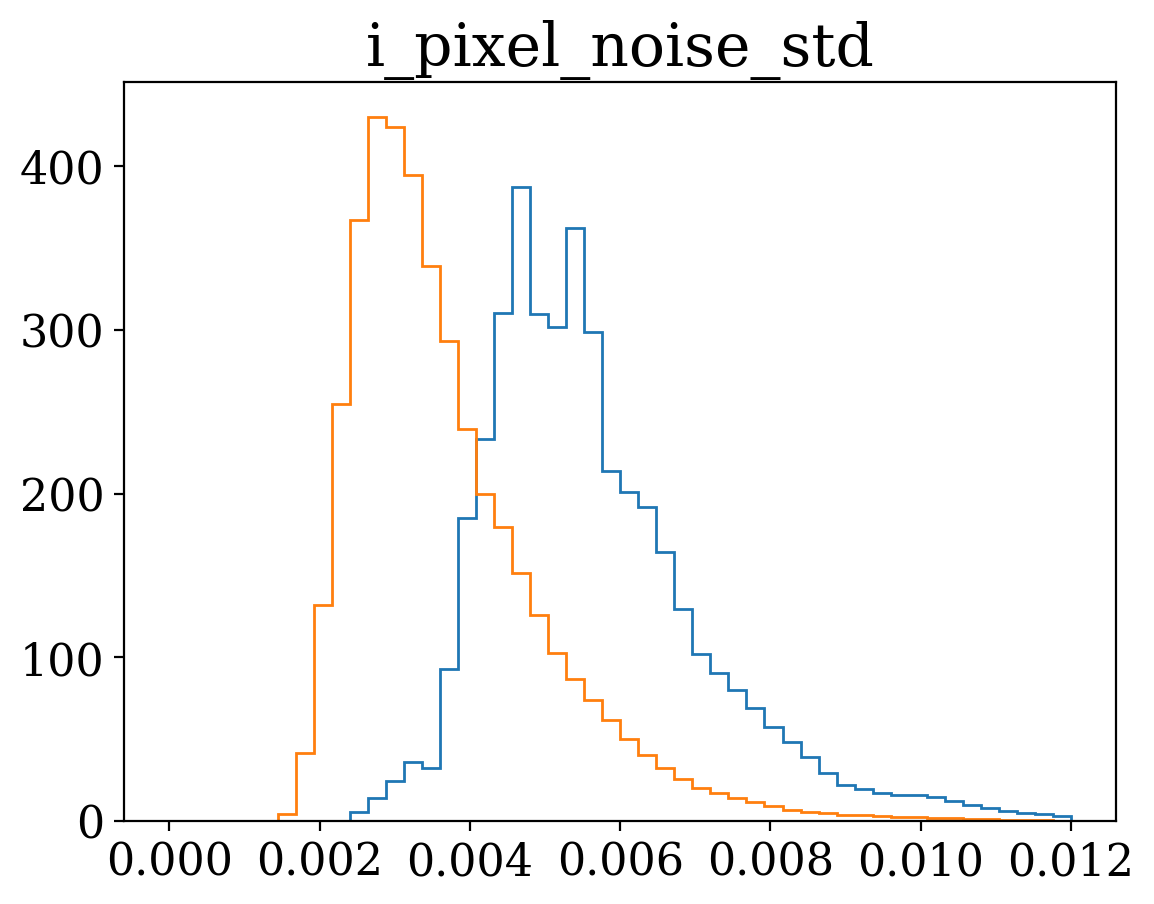

In [57]:
plt.hist(d2["i_variance_value"], bins=50, range=(0.0,1.2e-2), histtype="step", density=True)
plt.hist(d["i_variance_value"], bins=50, range=(0.0,1.2e-2), histtype="step", density=True)
plt.title("i_pixel_noise_std")

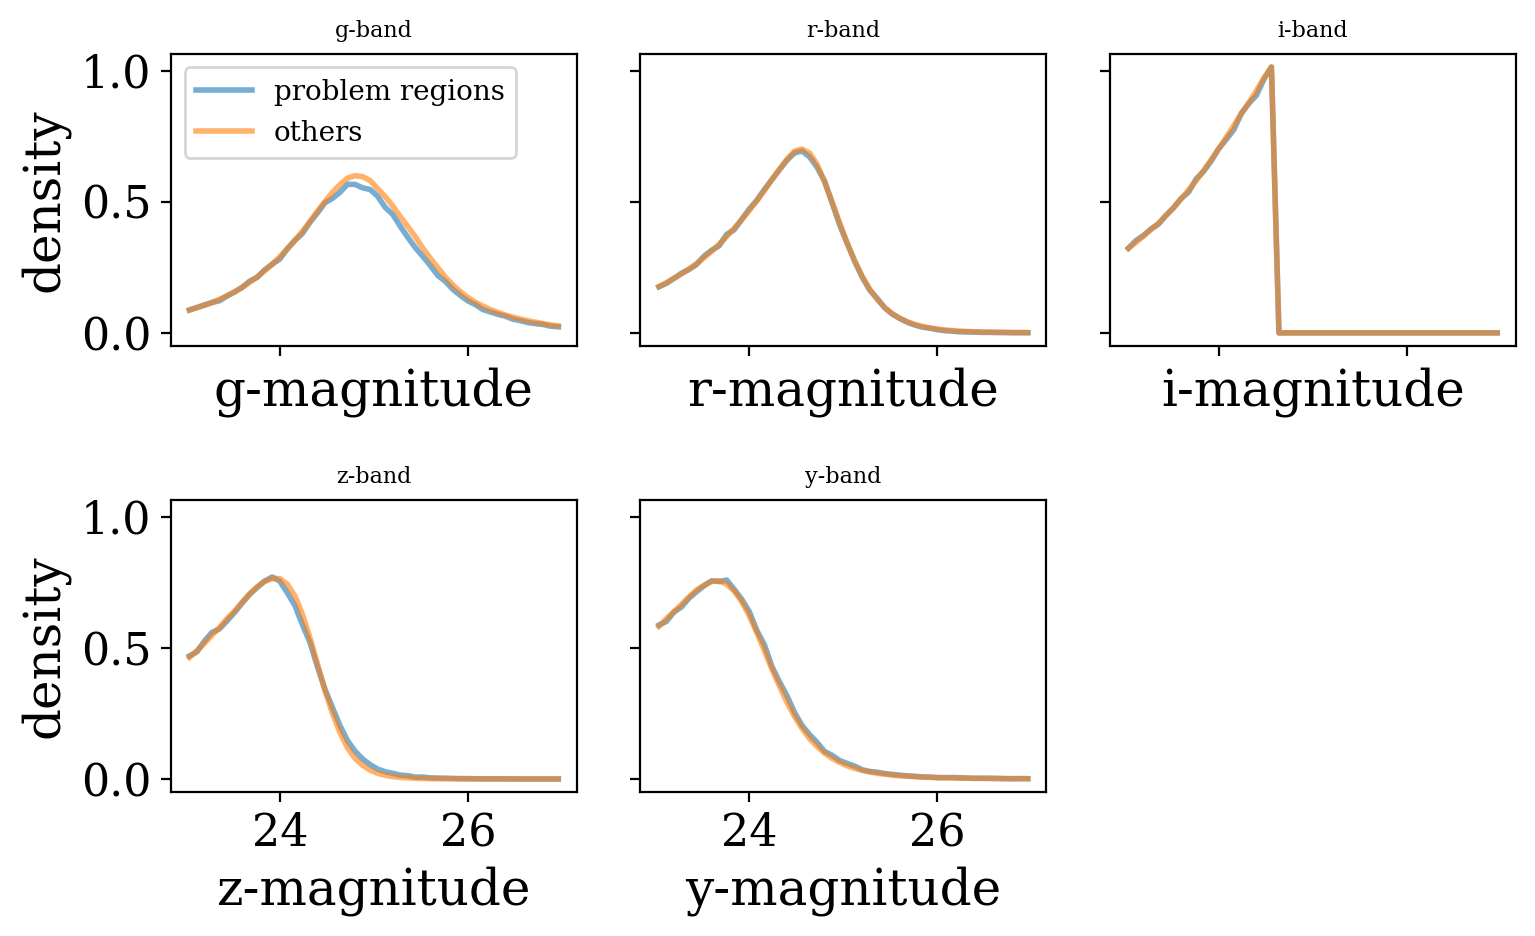

In [96]:
bands = ["g", "r", "i", "z", "y"]

# (keep your original selection: i-band cut; change "i" -> band if you want per-band cuts)
m1_base = (27.0 - 2.5 * np.log10(dd2["i_flux_gauss2"])) < 24.6
m2_base = (27.0 - 2.5 * np.log10(dd["i_flux_gauss2"])) < 24.6

fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
axes = axes.ravel()

for k, band in enumerate(bands):
    ax = axes[k]

    # avoid log10 on non-positive flux
    f1 = dd2[f"{band}_flux_gauss2"]
    f2 = dd[f"{band}_flux_gauss2"]
    m1 = m1_base & np.isfinite(f1) & (f1 > 0)
    m2 = m2_base & np.isfinite(f2) & (f2 > 0)

    mag1 = 27.0 - 2.5 * np.log10(f1[m1])
    mag2 = 27.0 - 2.5 * np.log10(f2[m2])

    hist1, bins = np.histogram(mag1, bins=50, range=(23.0, 27.0), density=True)
    hist2, _    = np.histogram(mag2, bins=50, range=(23.0, 27.0), density=True)

    centers = (bins[1:] + bins[:-1]) / 2.0

    # rescale "others" to match "problem regions" for centers < 24
    s1 = np.sum(hist1[centers < 24.0])
    s2 = np.sum(hist2[centers < 24.0])
    if s2 > 0:
        hist2 = hist2 * (s1 / s2)
        

    ax.plot(centers, hist1, alpha=0.6, label="problem regions")
    ax.plot(centers, hist2, alpha=0.6, label="others")
    ax.set_title(f"{band}-band", fontsize=8)
    ax.set_xlabel(f"{band}-magnitude")
    if k % 3 == 0:
        ax.set_ylabel("density")
    if k==0:
        ax.legend(loc="upper left", fontsize=10)

# 6th panel (unused): hide it
axes[5].axis("off")

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'i_pixel_noise_std')

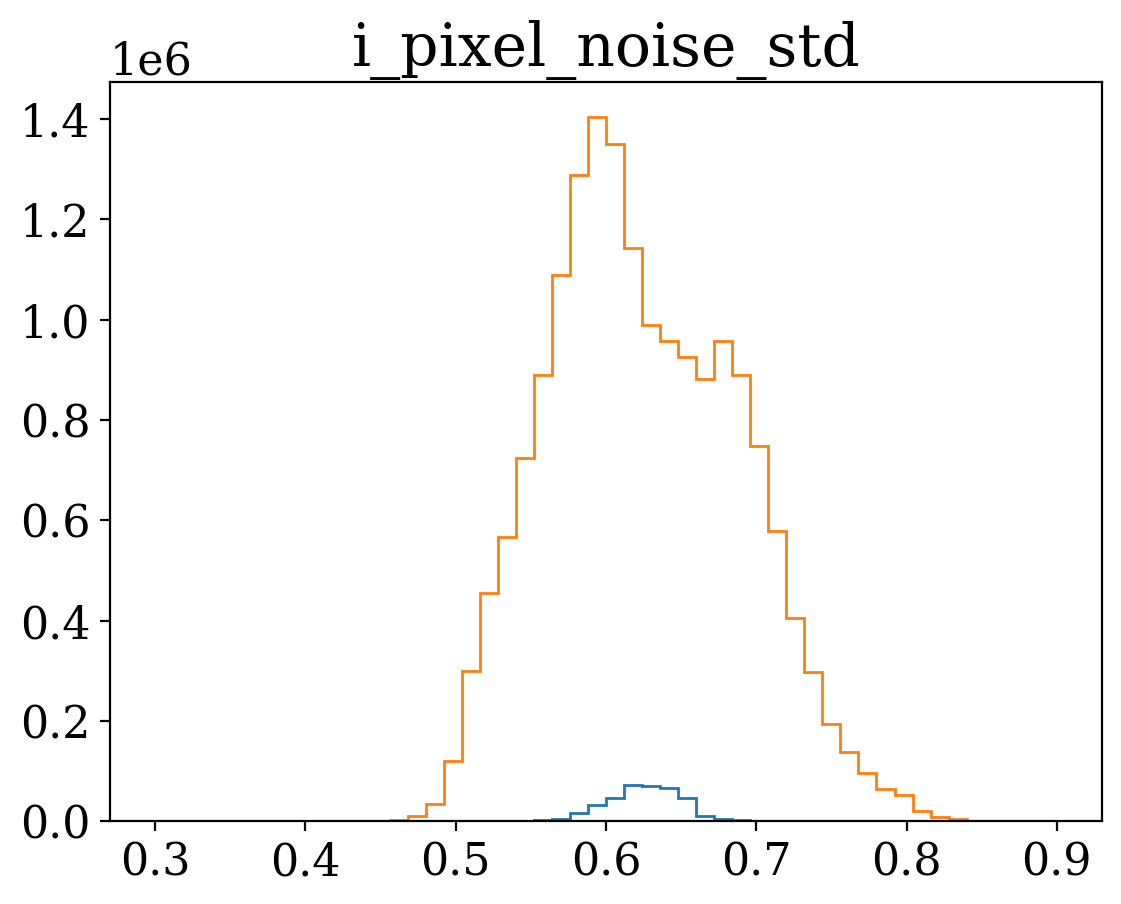

In [67]:
def get_psf_fwhm(data):
    fwhm = (
        data["i_hsmpsfmoments_shape11"] * data["i_hsmpsfmoments_shape22"] 
        - data["i_hsmpsfmoments_shape12"] * data["i_hsmpsfmoments_shape12"]
    ) ** (0.25) * 2.335
    return fwhm
plt.hist(get_psf_fwhm(d2), bins=50, range=(0.3,0.9), histtype="step")
plt.hist(get_psf_fwhm(d), bins=50, range=(0.3,0.9), histtype="step")
plt.title("i_pixel_noise_std")

/gpfs02/work/xiangchong.li/work/tmp/ipykernel_24012/2639668406.py:13: RuntimeWarning: invalid value encountered in log10
  x1 = 2.5 * np.log10(dd2[f"{band4}_flux_gauss2"][sel1] / dd2[f"{band3}_flux_gauss2"][sel1])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_24012/2639668406.py:14: RuntimeWarning: invalid value encountered in log10
  y1 = 2.5 * np.log10(dd2[f"{band2}_flux_gauss2"][sel1] / dd2[f"{band1}_flux_gauss2"][sel1])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_24012/2639668406.py:16: RuntimeWarning: invalid value encountered in log10
  x2 = 2.5 * np.log10(dd[f"{band4}_flux_gauss2"][sel2] / dd[f"{band3}_flux_gauss2"][sel2])
/gpfs02/work/xiangchong.li/work/tmp/ipykernel_24012/2639668406.py:17: RuntimeWarning: invalid value encountered in log10
  y2 = 2.5 * np.log10(dd[f"{band2}_flux_gauss2"][sel2] / dd[f"{band1}_flux_gauss2"][sel2])


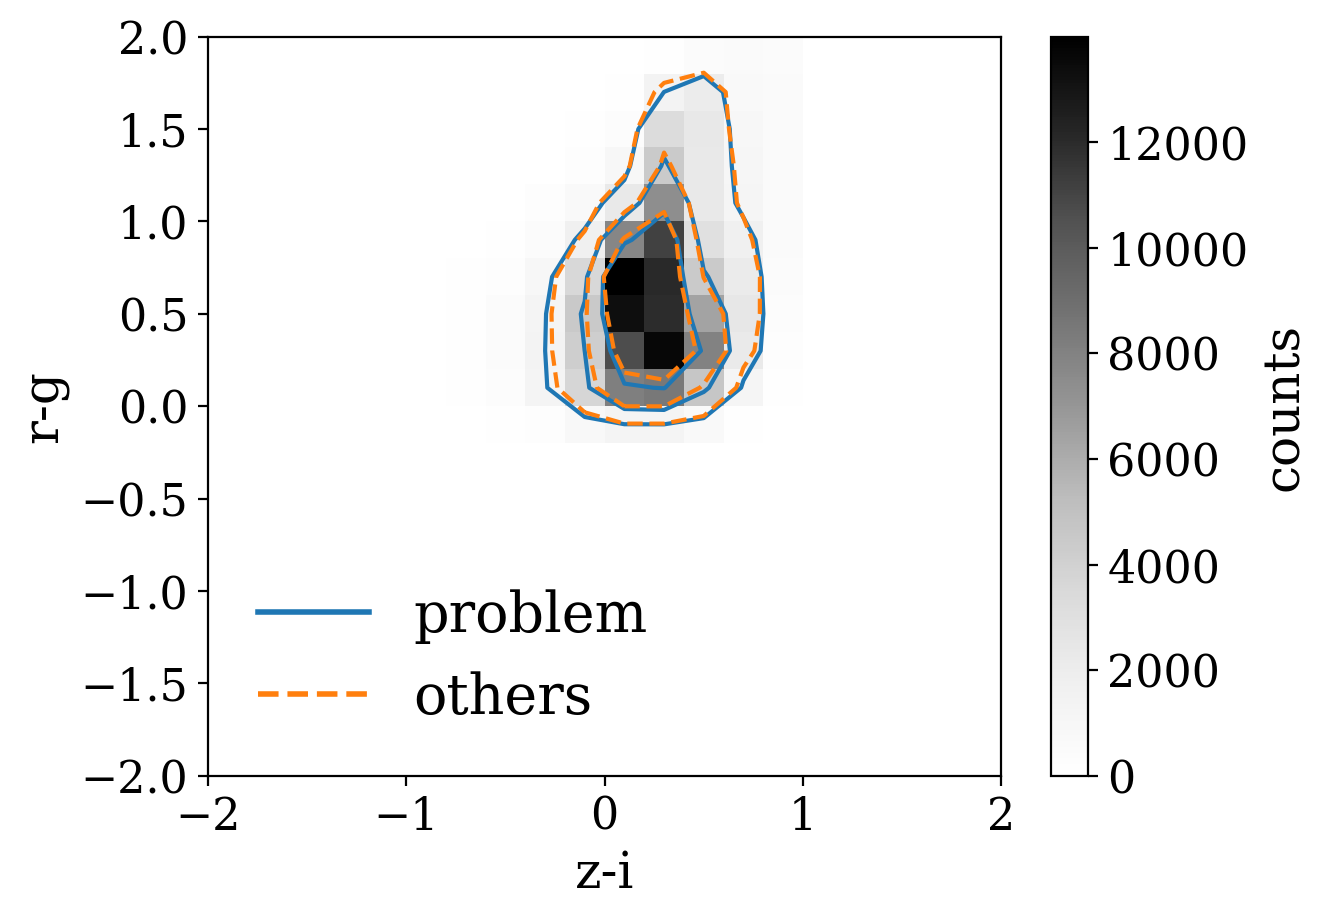

In [118]:
band1 = "g"
band2 = "r"
band3 = "i"
band4 = "z"

sel1 = (27.0 - 2.5 * np.log10(dd2["i_flux_gauss2"])) < 24.6
sel2 = (27.0 - 2.5 * np.log10(dd["i_flux_gauss2"])) < 24.6

# Colors: x = (z-i), y = (r-g)
x1 = 2.5 * np.log10(dd2[f"{band4}_flux_gauss2"][sel1] / dd2[f"{band3}_flux_gauss2"][sel1])
y1 = 2.5 * np.log10(dd2[f"{band2}_flux_gauss2"][sel1] / dd2[f"{band1}_flux_gauss2"][sel1])

x2 = 2.5 * np.log10(dd[f"{band4}_flux_gauss2"][sel2] / dd[f"{band3}_flux_gauss2"][sel2])
y2 = 2.5 * np.log10(dd[f"{band2}_flux_gauss2"][sel2] / dd[f"{band1}_flux_gauss2"][sel2])

# Optional: guard against non-positive flux ratios producing inf/nan
m1 = np.isfinite(x1) & np.isfinite(y1)
m2 = np.isfinite(x2) & np.isfinite(y2)
x1, y1 = x1[m1], y1[m1]
x2, y2 = x2[m2], y2[m2]

bins = 20
rng = [[-2, 2], [-2, 2]]

H1, xedges, yedges = np.histogram2d(x1, y1, bins=bins, range=rng)
H2, _,      _      = np.histogram2d(x2, y2, bins=[xedges, yedges])

# Background colormap (grey) from dd2
fig, ax = plt.subplots()
pm = ax.pcolormesh(xedges, yedges, H1.T, cmap="Greys", shading="auto")
plt.colorbar(pm, ax=ax, label="counts")

# Contours for BOTH datasets
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xc, yc, indexing="xy")

# Choose contour levels (fractions of each map's max)
def levels_from(H, fracs=(0.1, 0.3, 0.6)):
    hmax = H.max()
    return [f * hmax for f in fracs if f * hmax > 0]

ax.contour(Xc, Yc, H1.T, levels=levels_from(H1), linewidths=1.5, colors="C0", linestyles="-")
ax.contour(Xc, Yc, H2.T, levels=levels_from(H2), linewidths=1.5, colors="C1", linestyles="--")

ax.set_xlim(rng[0]); ax.set_ylim(rng[1])
ax.set_xlabel(f"{band4}-{band3}")
ax.set_ylabel(f"{band2}-{band1}")
ax.legend(
    handles=[
        plt.Line2D([], [], color="C0", ls="-",  label="problem"),
        plt.Line2D([], [], color="C1", ls="--", label="others"),
    ],
    frameon=False,
    loc="lower left"
)
plt.show()

In [144]:
np.std(dd["e1"]), np.std(dd["e2"])

(0.12398528047532167, 0.12506503188152027)

In [145]:
np.average(dd["dwsel_dg1"] * dd["e1"]), np.average(dd["dwsel_dg2"] * dd["e2"])

(-0.037712810887182875, -0.033263508691480766)

In [146]:
np.average(dd["de1_dg1"]), np.average(dd["de2_dg2"])

(0.28611846239429356, 0.28620670274560284)

In [147]:
np.average(dd["de2_dg1"] * dd["e1"] * dd["e2"]), np.average(dd["de1_dg2"] * dd["e1"] * dd["e2"])

(-0.0003480900195038081, -0.0003474354115949074)

In [149]:
np.std(dd["de1_dg2"]), np.std(dd["de2_dg1"])

(0.22025244929277368, 0.22026439591491456)

In [4]:
s1 = 0.0
s2 = 0.0
nn = 0.0
for fn in ["hectomap", "spring1", "spring2", "spring3", "autumn1"]:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/{fn}.fits"
    a = fitsio.read(fname)
    s1 = s1 + np.sum(a["dwsel_dg1"] * a["e1"])
    s2 = s2 + np.sum(a["dwsel_dg2"] * a["e2"])
    nn = nn + len(a)

print(s1 / nn, s2 / nn)

In [9]:
for fn in ["hectomap", "spring1", "spring2", "spring3", "autumn1"]:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal_v2/fields/{fn}.fits"
    a = fitsio.read(fname, columns=["object_id"])
    print(len(a))
    fname= f"/gpfs02/work/xiangchong.li/work/hsc_data/catalog_v2/s23b_shape/anacal_{fn}.fits"
    b = fitsio.read(fname, columns=["object_id"])
    print(len(b))

5657678
5657678
17593736
17593736
19568920
19568920
20036593
20036593
16923473
16923473


In [2]:
fn = "hectomap"
fname= f"/gpfs02/work/xiangchong.li/work/hsc_data/catalog_v2/s23b_shape/anacal_{fn}.fits"
a = fitsio.read(fname)

In [3]:
a.dtype.names

('object_id',
 'ra',
 'dec',
 'e1',
 'e2',
 'g_flux_gauss2',
 'g_dflux_gauss2_dg1',
 'g_dflux_gauss2_dg2',
 'g_flux_gauss4',
 'g_dflux_gauss4_dg1',
 'g_dflux_gauss4_dg2',
 'g_flux_gauss2_err',
 'g_flux_gauss4_err',
 'r_flux_gauss2',
 'r_dflux_gauss2_dg1',
 'r_dflux_gauss2_dg2',
 'r_flux_gauss4',
 'r_dflux_gauss4_dg1',
 'r_dflux_gauss4_dg2',
 'r_flux_gauss2_err',
 'r_flux_gauss4_err',
 'i_flux_gauss2',
 'i_dflux_gauss2_dg1',
 'i_dflux_gauss2_dg2',
 'i_flux_gauss4',
 'i_dflux_gauss4_dg1',
 'i_dflux_gauss4_dg2',
 'i_flux_gauss2_err',
 'i_flux_gauss4_err',
 'z_flux_gauss2',
 'z_dflux_gauss2_dg1',
 'z_dflux_gauss2_dg2',
 'z_flux_gauss4',
 'z_dflux_gauss4_dg1',
 'z_dflux_gauss4_dg2',
 'z_flux_gauss2_err',
 'z_flux_gauss4_err',
 'y_flux_gauss2',
 'y_dflux_gauss2_dg1',
 'y_dflux_gauss2_dg2',
 'y_flux_gauss4',
 'y_dflux_gauss4_dg1',
 'y_dflux_gauss4_dg2',
 'y_flux_gauss2_err',
 'y_flux_gauss4_err')